<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/tensorflow/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir data

In [3]:
!wget -O data/movie_genre.csv https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/data/movie_poster/MovieGenre.csv

--2019-12-10 18:20:26--  https://raw.githubusercontent.com/ashrefm/multi-label-soft-f1/master/data/movie_poster/MovieGenre.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9128209 (8.7M) [text/plain]
Saving to: ‘data/movie_genre.csv’

data/movie_genre.cs 100%[===================>]   8.71M  --.-KB/s    in 0.06s   

2019-12-10 18:20:32 (136 MB/s) - ‘data/movie_genre.csv’ saved [9128209/9128209]



## Installing Packages

In [4]:
!pip3 install "tensorflow_hub>=0.6.0" --user

In [5]:
!pip3 install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 36kB/s 
     |████████████████████████████████| 450kB 50.3MB/s 
     |████████████████████████████████| 3.8MB 45.1MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [6]:
!ls data/

movie_genre.csv


In [0]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub 
from time import time
import urllib.request
import warnings
warnings.filterwarnings('ignore')

In [0]:
sns.set_style("whitegrid")

In [0]:
movies = pd.read_csv('data/movie_genre.csv', encoding="ISO-8859-1")

In [10]:
movies.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [11]:
movies.shape

(40108, 6)

## Downloading Images

In [0]:
data_path = Path('data/images')

In [13]:
data_path.absolute()

PosixPath('/content/data/images')

In [0]:
movies['local_path'] = movies['imdbId'].apply(lambda x: data_path.joinpath(str(x) + '.jpg'))

In [15]:
movies.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,local_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,data/images/114709.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,data/images/113497.jpg
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/113228.jpg
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/114885.jpg
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/113041.jpg


In [0]:
!mkdir data/images

In [0]:
def download_image(pair):
    url = pair[0]
    filename = pair[1]
    if not Path(filename).exists():
      try:
        urllib.request.urlretrieve(url, filename)
        return 0
      except:
        return Path(filename).name

In [0]:
def download_images_parallely(data):
    pool = mp.Pool(processes=mp.cpu_count())
    paths = data['local_path'].tolist()
    urls = data['Poster'].tolist()
    results = [pool.map(download_image, [pair for pair in zip(urls, paths)])]
    pool.close()
    return results

In [19]:
mp.cpu_count()

2

In [0]:
results = download_images_parallely(movies)

In [21]:
len(results)

1

In [22]:
!ls data/images/ | wc -l

37293


In [23]:
movies.shape

(40108, 7)

In [0]:
failed_downloads = list(set(results[0]))

In [25]:
len(failed_downloads)

2224

In [26]:
failed_downloads[:5]

[0, '109040.jpg', '39490.jpg', '1530970.jpg', '161292.jpg']

In [0]:
failed_downloads.remove(None)
failed_downloads.remove(0)

In [28]:
len(failed_downloads)

2222

In [29]:
pd.Series(failed_downloads).str.split('.').apply(lambda x: x[0] if len(x)>0 else '')

0        109040
1         39490
2       1530970
3        161292
4         85863
         ...   
2217      80684
2218     478049
2219    1543055
2220    3216510
2221      73345
Length: 2222, dtype: object

In [0]:
movies_downloaded = movies.loc[~movies['imdbId'].isin(pd.Series(failed_downloads).str.split('.').apply(lambda x: x[0]))]

In [31]:
movies_downloaded.shape

(37873, 7)

In [0]:
movies_downloaded = movies_downloaded.loc[~movies_downloaded['Genre'].isnull()]

In [33]:
movies_downloaded.shape

(37755, 7)

In [34]:
movies_downloaded.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,local_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,data/images/114709.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,data/images/113497.jpg
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/113228.jpg
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/114885.jpg
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,data/images/113041.jpg


In [0]:
def get_counts(data, field, sep):
    return data[field].apply(lambda s: str(s).split(sep)).apply(pd.Series).melt(value_name='counts')['counts'].value_counts().sort_values(ascending=False)

In [0]:
label_freq = get_counts(movies_downloaded, field='Genre', sep='|')

In [37]:
label_freq

Drama          19087
Comedy         12072
Romance         5920
Action          5062
Crime           5002
Thriller        4602
Horror          3821
Adventure       3649
Documentary     3524
Mystery         2277
Family          1984
Fantasy         1929
Biography       1904
Sci-Fi          1904
Animation       1644
History         1363
Music           1231
War             1124
Short            889
Western          800
Musical          795
Sport            673
Film-Noir        381
News              79
Adult              8
Talk-Show          6
Reality-TV         2
Game-Show          1
Name: counts, dtype: int64

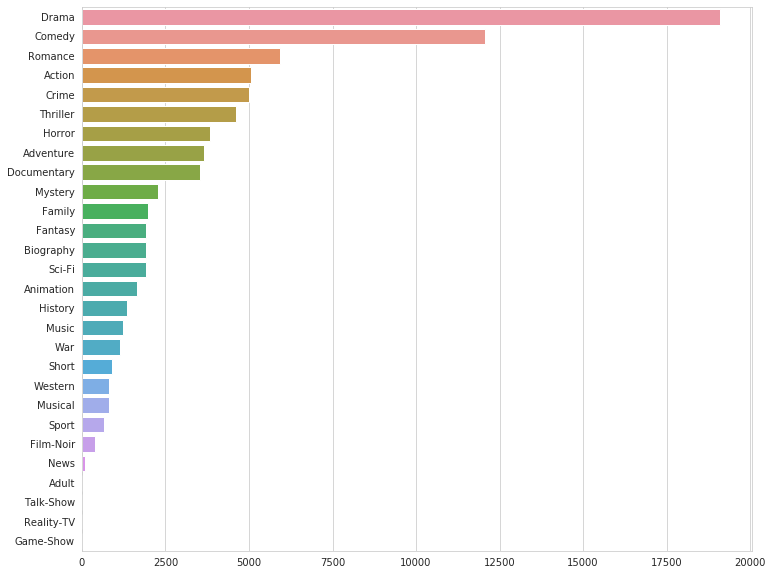

In [38]:
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index, x=label_freq.values, orient='h')

In [0]:
movies_downloaded['Genre'] = movies_downloaded['Genre'].apply(lambda x: str(x).split('|'))

In [40]:
movies_downloaded['Genre'].head()

0    [Animation, Adventure, Comedy]
1       [Action, Adventure, Family]
2                 [Comedy, Romance]
3          [Comedy, Drama, Romance]
4         [Comedy, Family, Romance]
Name: Genre, dtype: object

In [0]:
X_train, X_val, y_train, y_val = train_test_split(movies_downloaded['local_path'], movies_downloaded['Genre'], test_size=0.2)

In [42]:
print(f"Train: {X_train.shape[0]}")
print(f"Test: {X_val.shape[0]}")

Train: 30204
Test: 7551


Since, there are multiple labels, we use MultiLabelBinarizer.

In [0]:
mlb = MultiLabelBinarizer()
mlb.fit(movies_downloaded['Genre'].values)
y_train_binarized = mlb.transform(y_train)
y_val_binarized = mlb.transform(y_val)

In [0]:
def display(idx):
    print(f"X: {X_train.values[idx]}\ny_train: {y_train[idx]}\ny_binarized: {y_train_binarized[idx]}")

In [0]:
pd.set_option('display.max_columns', 100)

In [46]:
pd.DataFrame(mlb.fit_transform(movies_downloaded['Genre'].values), columns=mlb.classes_, index=movies_downloaded.index).head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Preparing Data

In [0]:
IMG_SIZE = 224
BATCH_SIZE = 256 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024
CHANNELS = 3
EPOCHS = 10

In [0]:
def parse_single_pair(filename, labels):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img/255.0
    return img, labels

In [0]:
X_train = X_train.apply(lambda x: str(x))
X_val = X_val.apply(lambda x: str(x))

In [0]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_binarized))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_binarized))

In [0]:
train_data = train_data.map(parse_single_pair, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(parse_single_pair, num_parallel_calls=AUTOTUNE)

In [0]:
train_data = train_data.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
val_data = val_data.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

In [0]:
train_data = train_data.batch(BATCH_SIZE)
val_data = val_data.batch(BATCH_SIZE)

In [54]:
train_data.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None, 28)), types: (tf.float32, tf.int64)>

## Transfer Learning

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [56]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.experimental.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.experimental.list_physical_devices('GPU')` instead.


True

In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(28, activation='sigmoid', name='output')
])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 28)                14364     
Total params: 4,108,892
Trainable params: 1,850,908
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.math.reduce_mean(f1)

In [0]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [0]:
model.compile(optimizer='adam', loss=f1_loss, metrics=[f1_metric], experimental_run_tf_function=False)

In [0]:
start = time()

In [64]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data
                    )

print('\nTraining took {}'.format(time() - start))

Epoch 1/10
118/118 [==============================] - 142s 1s/step - loss: 0.8093 - f1_metric: 0.1943 - val_loss: 0.7954 - val_f1_metric: 0.2068
Epoch 2/10
118/118 [==============================] - 133s 1s/step - loss: 0.7805 - f1_metric: 0.2210 - val_loss: 0.7853 - val_f1_metric: 0.2152
Epoch 3/10
118/118 [==============================] - 132s 1s/step - loss: 0.7702 - f1_metric: 0.2312 - val_loss: 0.7793 - val_f1_metric: 0.2214
Epoch 4/10
118/118 [==============================] - 132s 1s/step - loss: 0.7619 - f1_metric: 0.2391 - val_loss: 0.7826 - val_f1_metric: 0.2178
Epoch 5/10
118/118 [==============================] - 132s 1s/step - loss: 0.7562 - f1_metric: 0.2455 - val_loss: 0.7723 - val_f1_metric: 0.2277
Epoch 6/10
118/118 [==============================] - 132s 1s/step - loss: 0.7507 - f1_metric: 0.2499 - val_loss: 0.7716 - val_f1_metric: 0.2286
Epoch 7/10
118/118 [==============================] - 131s 1s/step - loss: 0.7459 - f1_metric: 0.2551 - val_loss: 0.7667 - val_f1_

In [0]:
def show_prediction(title, movies_df, model):
    sample = movies_df.loc[movies_df['Title']==title]
    imdbId = sample['imdbId'].values[0]
    genre = sample['Genre'].values[0]
    img_path = sample['local_path'].values[0]

    # Read and prepare image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE, CHANNELS))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    plt.style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title(f'\n\n{title}\n\nGenre\n{genre}\n\nPrediction\n{list(prediction)}\n')
    plt.show()

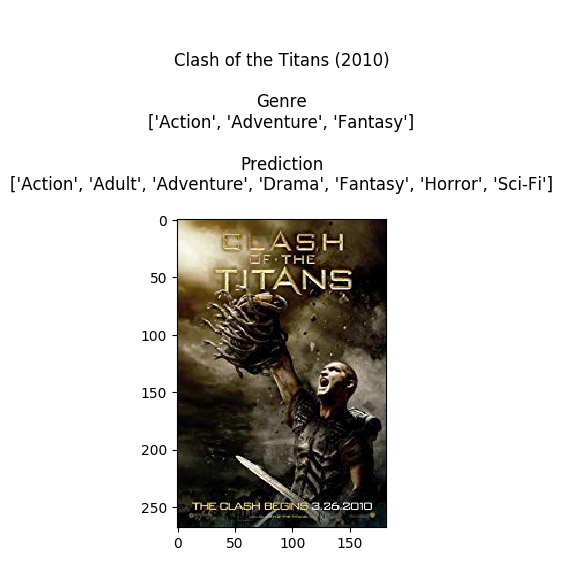

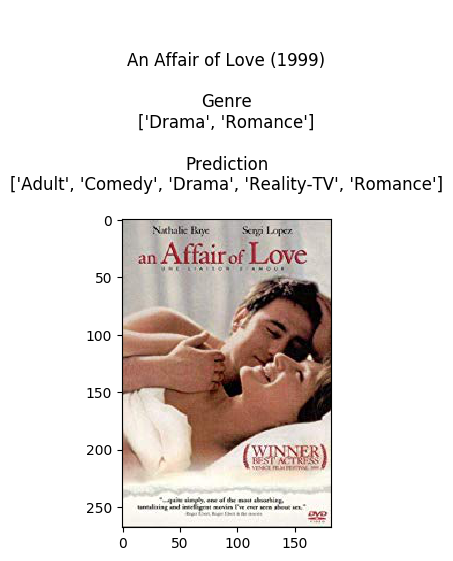

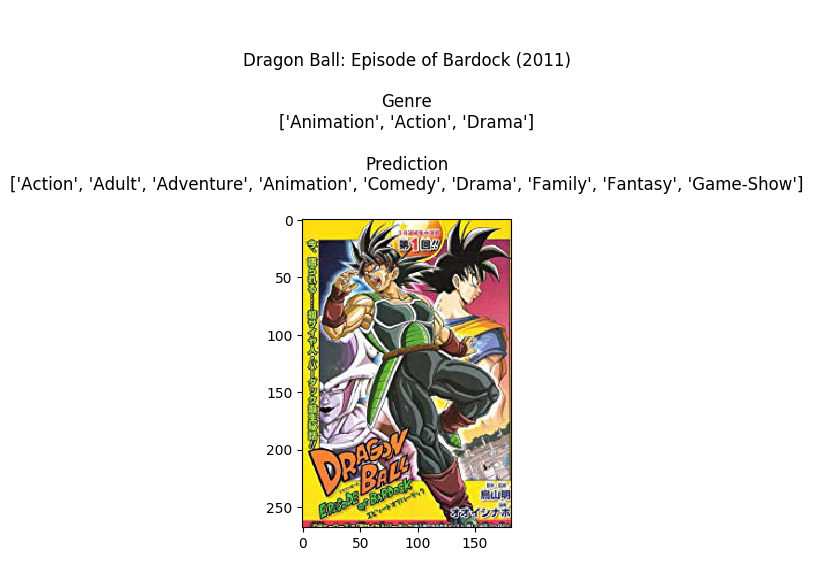

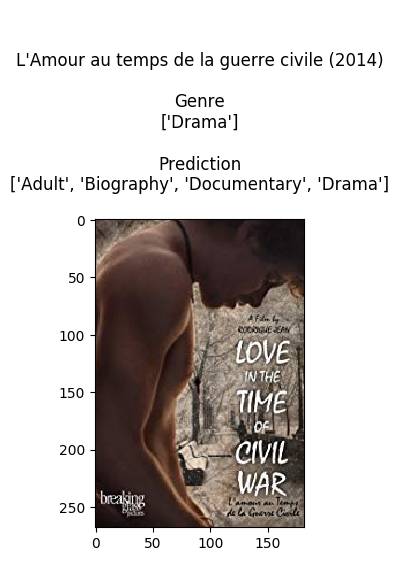

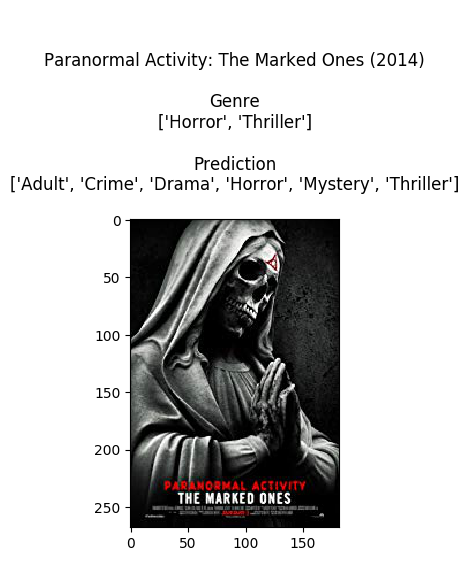

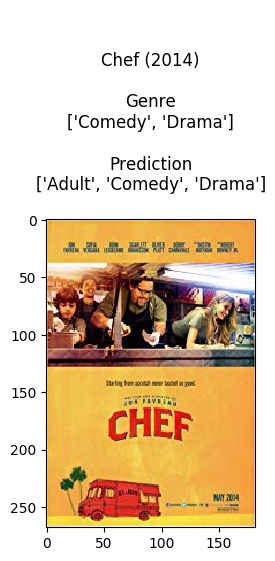

In [66]:
titles = ["Clash of the Titans (2010)",
          "An Affair of Love (1999)",
          "Dragon Ball: Episode of Bardock (2011)",
          "L'Amour au temps de la guerre civile (2014)",
          "Paranormal Activity: The Marked Ones (2014)",
          "Chef (2014)"]

for t in titles:
    show_prediction(t, movies_downloaded, model)